In [ ]:
from dotenv import load_dotenv
from pydantic import BaseModel
from typing import Annotated, Any, Dict
import gradio as gr
import uuid
from IPython.display import Image, display
from langgraph.graph import StateGraph, END, START
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain.agents import Tool

In [17]:
load_dotenv(override=True)

True

In [18]:
serper = GoogleSerperAPIWrapper()

tool_search = Tool(
        name="web_search",
        func=serper.run,
        description="Useful for when you need more information from an online search"
)

In [19]:
tools = [tool_search]

In [20]:
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

In [21]:
class State(BaseModel):
    messages: Annotated[list[Any], add_messages]
    topic: str
    number_of_classes: int

In [22]:
graph_builder = StateGraph(State)

In [ ]:

def node_outline_generator(state: State) -> Dict[str, Any]:
    system_message = "You are a helpful educational assistant."
    user_message= f"""
    Please create a course outline on '{state.topic}' with {state.number_of_classes} classes.
    If necessary, use the available tools to gather more information.
    Format the response in markdown with class titles as headings and bullet points for key topics under each class.
    """

    messages = [SystemMessage(content=system_message), HumanMessage(content=user_message)]
    messages += state.messages

    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}


In [24]:
graph_builder.add_node("generate_course_outline", node_outline_generator)
graph_builder.add_node("tools", ToolNode(tools=tools))

In [25]:
graph_builder.add_edge(START, "generate_course_outline")
graph_builder.add_conditional_edges( "generate_course_outline", tools_condition, {"tools":'tools', "__end__": END})
graph_builder.add_edge("tools", "generate_course_outline")

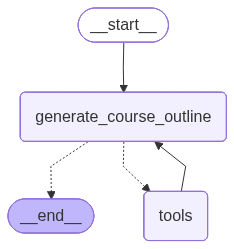

In [26]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [30]:
def make_thread_id() -> str:
    return str(uuid.uuid4())

In [ ]:
from backend.agent.prompt_enhancer import prompt_enhancer

result =  prompt_enhancer("Create a lesson plan about photosynthesis.", "Photosynthesis", 3)

In [2]:
result

'"Create a detailed course outline about photosynthesis, including key topics to cover, learning objectives, suggested activities, assessments, and any necessary resources. Please organize the outline into modules or sections, specifying the progression of concepts from basic to advanced."'